# Problem Set 1: "Building a Strategic Portfolio"

In [176]:
# import packages
import pandas as pd
import numpy as np
import yfinance
import matplotlib.pylab as plt
import scipy.stats
import statsmodels.api as sm

In [177]:
#load data from yfinance

#yfinance.download(['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V', '^GSPC'], interval='1mo')['Close'].dropna().to_csv('data.csv')

# load data from csv file

data = pd.read_csv('data.csv', index_col=['Date'], date_format=['Date'])

data.head()

,AAPL,MSFT,ORSTED.CO,TSLA,V,^GSPC
Date,,,,,,
2016-06-01,21.849648,45.602215,210.907013,14.152000,69.670120,2098.860107
2016-07-01,23.817484,50.512680,237.851852,15.652667,73.314705,2173.600098
2016-08-01,24.249447,51.207809,232.322479,14.134000,75.991806,2170.949951
2016-09-01,25.977856,51.652515,241.362595,13.602000,77.817375,2168.270020
2016-10-01,26.090462,53.732948,235.833191,13.182000,77.638618,2126.149902


In [178]:
#get log-return

ticker = ['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V', '^GSPC']

for i in range(len(ticker)):
    data.loc[:, "logreturn_" + ticker[i]] = np.log(data[ticker[i]]) - np.log(data[ticker[i]].shift())

data = data.dropna()

data.head()

,AAPL,MSFT,ORSTED.CO,TSLA,V,^GSPC,logreturn_AAPL,logreturn_MSFT,logreturn_TSLA,logreturn_ORSTED.CO,logreturn_V,logreturn_^GSPC
Date,,,,,,,,,,,,
2016-07-01,23.817484,50.512680,237.851852,15.652667,73.314705,2173.600098,0.086235,0.102268,0.100785,0.120231,0.050990,0.034990
2016-08-01,24.249447,51.207809,232.322479,14.134000,75.991806,2170.949951,0.017974,0.013668,-0.102058,-0.023522,0.035864,-0.001220
2016-09-01,25.977856,51.652515,241.362595,13.602000,77.817375,2168.270020,0.068851,0.008647,-0.038366,0.038174,0.023739,-0.001235
2016-10-01,26.090462,53.732948,235.833191,13.182000,77.638618,2126.149902,0.004325,0.039487,-0.031365,-0.023176,-0.002300,-0.019617
2016-11-01,25.396496,54.037853,210.204895,12.626667,72.755035,2198.810059,-0.026959,0.005658,-0.043041,-0.115042,-0.064967,0.033604


# Jarque-Bera test for normality

In [179]:
#remove sp500 from ticker list
ticker = ['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V']

JB = np.zeros((len(ticker)))

for i in range(len(ticker)):
    S = scipy.stats.skew(data["logreturn_" + ticker[i]])
    K = scipy.stats.kurtosis(data["logreturn_" + ticker[i]], fisher=False)
    N = data.shape[0]
    JB[i] = (N / 6) * (S**2 + 0.25 * (K - 3)**2)


JB

array([1.58036466, 0.19358789, 1.63753842, 4.99006413, 1.43771783])

In [180]:
cdf = np.zeros((len(ticker)))

for i in range(len(ticker)):
    cdf[i] = scipy.stats.chi2.cdf(JB[i], 2)

cdf

array([0.54623795, 0.09225697, 0.55902593, 0.91750619, 0.512692  ])

In [181]:
a = 0.05

p = np.zeros((len(ticker)))

for i in range(len(ticker)):
    p[i] = 1 - cdf[i]
    if p[i] > a:
        print(ticker[i] + ": probably normal distributed")
    else: 
        print(ticker[i] + ": not normal distributen")

AAPL: probably normal distributed
MSFT: probably normal distributed
TSLA: probably normal distributed
ORSTED.CO: probably normal distributed
V: probably normal distributed


# Build the IOS

In [182]:
mu = np.zeros((len(ticker)))

for i in range(len(ticker)):
    mu[i] = np.mean(data["logreturn_" + ticker[i]])*12

Sigma = np.cov(data[['logreturn_AAPL', 'logreturn_MSFT', 'logreturn_TSLA', 'logreturn_ORSTED.CO', 'logreturn_V']].T)*12

print(mu)
print(Sigma)

[0.25313229 0.25893204 0.35722069 0.0172158  0.18662126]
[[0.07366581 0.03216465 0.08849165 0.0227637  0.0271015 ]
 [0.03216465 0.03874774 0.05130279 0.01307901 0.01870842]
 [0.08849165 0.05130279 0.36635139 0.02233752 0.02861921]
 [0.0227637  0.01307901 0.02233752 0.09280093 0.00944393]
 [0.0271015  0.01870842 0.02861921 0.00944393 0.03955567]]


# Building the MV-Frontier

## 1. Unconstrained

In [183]:
#SINGLE OPTIMIZATIONS: Objective Function, Constraint Function, Starting Values, Bounds

def portfolio_variance(w):
        #input: w as numpy column vector
        #output: scalar
    return (w.T@Sigma@w).item() #objective function to be minimized


def eq_portfolio_return(w):
    #input: numpy portfolio column vector
    #note: mu_i is a global variable; needs to be known before calling this function
    #output: difference between w's expected return and the target return; scalar
    
    return (w.T@mu).item() - mu_i #constraint to meet target expected return mu_i


def eq_weight_sum(w): 
    #content: full investment constraint: 100% is invested in risky assets
    #input: numpy portfolio column vector
    #output: difference between sum of portfolio holdings and 100%=1. 
    
    return np.sum(w) - 1


# starting values
w0 = [0.2, 0.2, 0.2, 0.2, 0.2]

#no short-sale (bound) and minimum diversification bound
bounds = [(0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5), (0, 0.5)]


constraints = [{'type': 'eq', 'fun': eq_portfolio_return},
               {'type': 'eq', 'fun': eq_weight_sum}
               ] #target return and full investment constraint

In [184]:
#Loop through y-axis (i.e. mu_i)

mu_min = 0.01
mu_max = 1
incr = 0.001

In [185]:
#number of evaluations
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

991

In [186]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 5))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, constraints=constraints)
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item() 
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_95443/1086647150.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


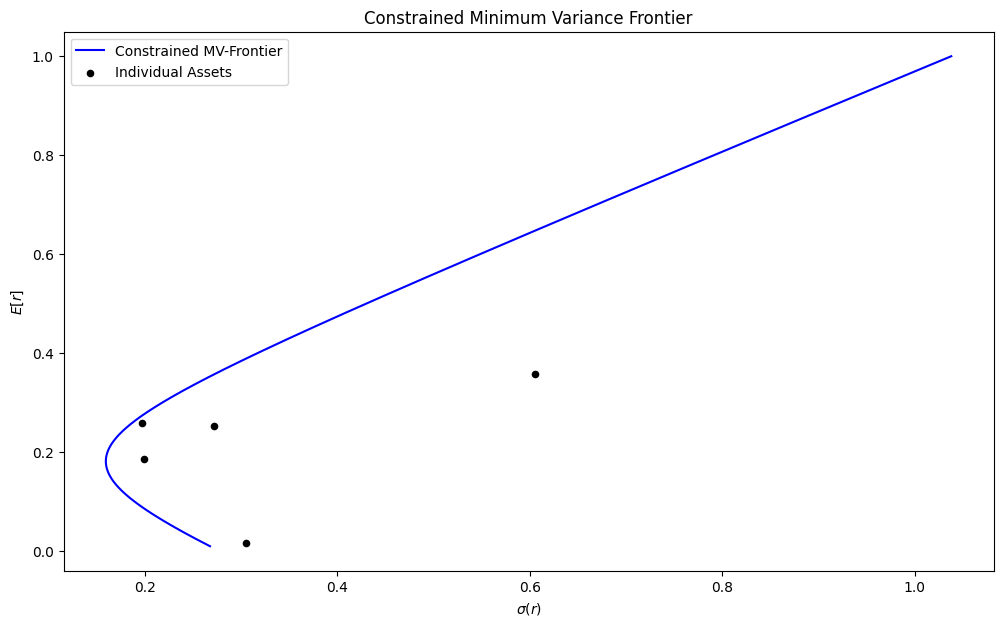

In [187]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities
plt.scatter(np.diag(Sigma)**0.5, mu[:], s=20, color='black', label='Individual Assets')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Constrained Minimum Variance Frontier')
plt.show()

## Constrained

In [188]:
#Loop through y-axis (i.e. mu_i)

mu_min = 0.01
mu_max = 1
incr = 0.001

In [189]:
#number of evaluations
nr_evals = int( (mu_max - mu_min) / incr + 1)
nr_evals #number of portfolios on the MV-frontier

991

In [190]:
# MV-Frontier

w_MV = np.zeros((nr_evals, 5))
mu_MV = np.zeros((nr_evals,))
sigma_MV = np.zeros((nr_evals,))

mu_i = mu_min
for i in range(0,nr_evals):
    w_opt = scipy.optimize.minimize(portfolio_variance, w0, bounds=bounds, constraints=constraints)
    w_MV[i,:] = w_opt.x
    mu_MV[i] = (w_opt.x.T@mu).item()  #MU: come back here.
    sigma_MV[i] = (w_opt.x.T@Sigma@w_opt.x).item()**0.5
    
    mu_i = mu_i + incr

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_95443/1086647150.py:12: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


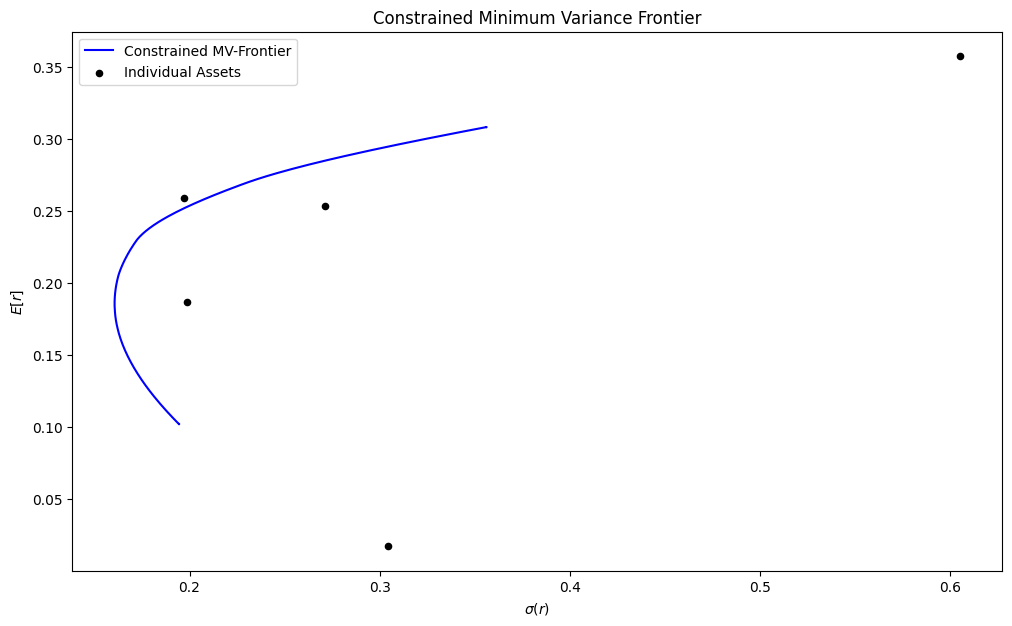

In [191]:
# Plot MV-Frontier

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities
plt.scatter(np.diag(Sigma)**0.5, mu[:], s=20, color='black', label='Individual Assets')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')

plt.legend()

#add a title
plt.title('Constrained Minimum Variance Frontier')
plt.show()

# Tangency Portfolio

In [192]:
rf = 0.027

SR_MV = (mu_MV - rf) / sigma_MV

TP_index = np.argmax(SR_MV)

TP_index

224

In [193]:
w_TP = w_MV[TP_index]
w_TP

array([0.14213467, 0.5       , 0.01037417, 0.        , 0.34749116])

In [194]:
mu_TP = mu_MV[TP_index]
mu_TP

0.23399999999098836

In [195]:
sigma_TP = sigma_MV[TP_index]
sigma_TP

0.17532911592130693

In [196]:
SR_TP = (mu_TP - rf) / sigma_TP
SR_TP

1.1806367636274189

# Optimal Complete Portfolio

In [197]:
A = 8

y = (mu_TP - rf) / (A * (sigma_TP ** 2))

y

0.8417289659959593

In [198]:
mu_C = y*mu_TP+(1-y)*rf 

sigma_C = y*sigma_TP

utility_C = mu_C - 0.5*A*(sigma_C**2)

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_95443/2998864789.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(r)$')


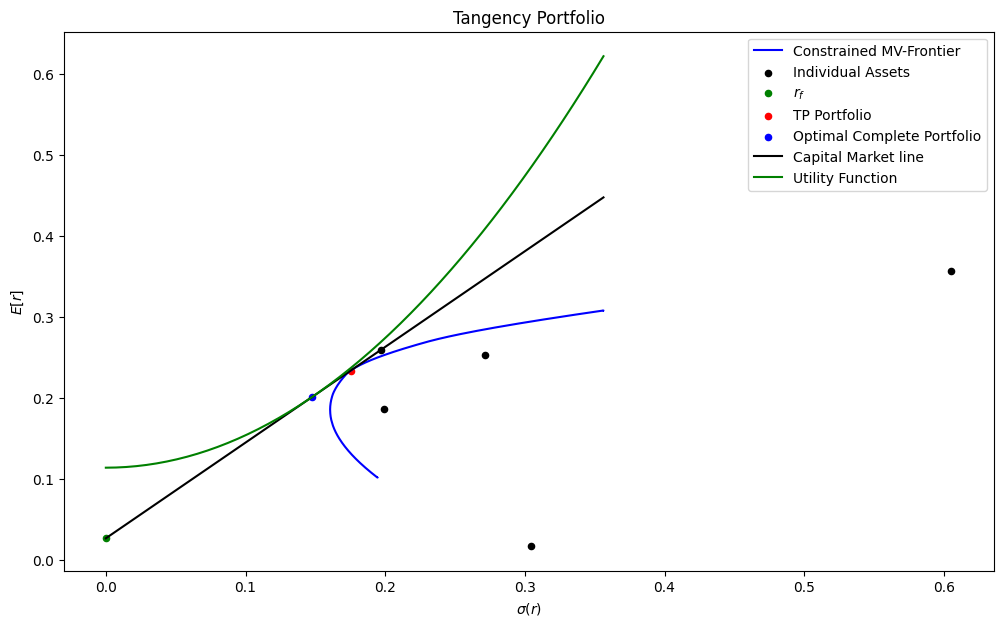

In [206]:
# Plot Tangency Portfolio

plt.figure(1, figsize=(12,7))

#show the MV-frontier that obeys constraints and bounds
plt.plot(sigma_MV, mu_MV, color='blue',label='Constrained MV-Frontier')

# add single assets investment opportunities and risk-free asset
plt.scatter(np.diag(Sigma)**0.5, mu, s=20, color='black', label='Individual Assets')
plt.scatter([0], [rf], s = 20, color='green', label='$r_f$')
plt.scatter(sigma_TP, mu_TP, s = 20, color='red', label='TP Portfolio')
plt.scatter(sigma_C, mu_C, s = 20, color='Blue', label='Optimal Complete Portfolio')

# add capital market line
x = np.linspace(0, np.max(sigma_MV))
y = rf + SR_TP * x
plt.plot(x, y, color='black', label='Capital Market line')

# add utility function
x = np.linspace(0, np.max(sigma_MV))
y = utility_C + 0.5*A*(x**2)
plt.plot(x, y, color='green', label='Utility Function')

#descrive axis
plt.xlabel('$\sigma(r)$')
plt.ylabel('$E[r]$')


plt.legend()

#add a title
plt.title('Tangency Portfolio')
plt.show()

# Decomposing expected portfolio performance (return and risk) into systematic ans idiosyncratic components

In [200]:
# add Sp500 to ticker list
ticker = ['AAPL', 'MSFT', 'TSLA', 'ORSTED.CO', 'V', '^GSPC']

# calc excess return
for i in range(len(ticker)):
    data["xr_" + ticker[i]] = data["logreturn_" + ticker[i]]


data.head()

,AAPL,MSFT,ORSTED.CO,TSLA,V,^GSPC,logreturn_AAPL,logreturn_MSFT,logreturn_TSLA,logreturn_ORSTED.CO,logreturn_V,logreturn_^GSPC,xr_AAPL,xr_MSFT,xr_TSLA,xr_ORSTED.CO,xr_V,xr_^GSPC
Date,,,,,,,,,,,,,,,,,,
2016-07-01,23.817484,50.512680,237.851852,15.652667,73.314705,2173.600098,0.086235,0.102268,0.100785,0.120231,0.050990,0.034990,0.086235,0.102268,0.100785,0.120231,0.050990,0.034990
2016-08-01,24.249447,51.207809,232.322479,14.134000,75.991806,2170.949951,0.017974,0.013668,-0.102058,-0.023522,0.035864,-0.001220,0.017974,0.013668,-0.102058,-0.023522,0.035864,-0.001220
2016-09-01,25.977856,51.652515,241.362595,13.602000,77.817375,2168.270020,0.068851,0.008647,-0.038366,0.038174,0.023739,-0.001235,0.068851,0.008647,-0.038366,0.038174,0.023739,-0.001235
2016-10-01,26.090462,53.732948,235.833191,13.182000,77.638618,2126.149902,0.004325,0.039487,-0.031365,-0.023176,-0.002300,-0.019617,0.004325,0.039487,-0.031365,-0.023176,-0.002300,-0.019617
2016-11-01,25.396496,54.037853,210.204895,12.626667,72.755035,2198.810059,-0.026959,0.005658,-0.043041,-0.115042,-0.064967,0.033604,-0.026959,0.005658,-0.043041,-0.115042,-0.064967,0.033604


In [201]:
# drop nan
data = data.dropna()

In [203]:
# CAPM Regression

y = data['xr_AAPL'].values
X = data['xr_^GSPC'].values
X = sm.add_constant(X)

model = sm.OLS(y, X)
model_fit = model.fit()

print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     82.16
Date:                Tue, 20 May 2025   Prob (F-statistic):           7.69e-15
Time:                        22:25:37   Log-Likelihood:                 152.08
No. Observations:                 107   AIC:                            -300.2
Df Residuals:                     105   BIC:                            -294.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0099      0.006      1.703      0.0